## Neural Collaborative Filtering (NCF) based Personalised Movie Recommender Engine (MovieLens)

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from tqdm.notebook import tqdm
np.random.seed(123)

In [2]:
# read data

rating_df = pd.read_csv('rating.csv', parse_dates=['timestamp'])

### Data Preprocessing

In [3]:
#use 40% data to reduce computational load and for quicker iteration
#randomly select users and use only their data

rand_users = np.random.choice(rating_df['userId'].unique(),
                              size=int(len(rating_df['userId'].unique())*0.4),
                              replace=False)

rating_df = rating_df.loc[rating_df['userId'].isin(rand_users)]

print('Reduced dataframe: {} rows for {} different users'.format(len(rating_df), len(rand_users)))

Reduced dataframe: 8022066 rows for 55397 different users


In [4]:
# TRAIN-TEST SPLIT
#leave-one-out-method, based on timestamp

#illustration
most_recents = rating_df[rating_df['userId'] == 138485].sort_values(by='timestamp', ascending=False)
most_recents.head(3)

#leave out the MOST RECENT review for test dataset, use other for training.

,userId,movieId,rating,timestamp


In [5]:
#Implement leave-one-out method

rating_df['latest_review'] = rating_df.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

X_rating = rating_df[rating_df['latest_review'] != 1]
Y_rating = rating_df[rating_df['latest_review'] == 1] #leave most recent for testing

X_rating = X_rating[['userId', 'movieId', 'rating']]
Y_rating = Y_rating[['userId', 'movieId', 'rating']]

### Feature Engineering

In [6]:
# convert explicit-to-implicit feedback

X_rating.loc[:, 'rating'] = 1

X_rating.sample(5)

,userId,movieId,rating
12170960,84070,1784,1.0
15509804,107266,2115,1.0
1750802,11851,53121,1.0
4061913,27640,590,1.0
12241441,84558,30793,1.0


In [7]:
# Generate 4 negative samples for each row, 4:1 ratio

movie_ids_unique = rating_df['movieId'].unique()

users = []
items = []
interacted = []

ui_interacted = set(zip(X_rating['userId'], X_rating['movieId']))

# 4:1 ratio
negatives = 4

for (u, i) in tqdm(ui_interacted):
    users.append(u)
    items.append(i)
    interacted.append(1)
    for _ in range(negatives):
        neg_item = np.random.choice(movie_ids_unique)
        while(u, neg_item) in ui_interacted:
            neg_item = np.random.choice(movie_ids_unique)
        users.append(u)
        items.append(neg_item)
        interacted.append(0)

  0%|          | 0/7966669 [00:00<?, ?it/s]

In [8]:
d = {'userId': users, 'movieId': items, 'interacted': interacted}
df = pd.DataFrame(data=d)
df.head()

,userId,movieId,interacted
0,5070,1270,1
1,5070,2297,0
2,5070,108501,0
3,5070,126591,0
4,5070,69278,0


In [31]:
# create pytorch dataset for training

class RatingTrainData(Dataset):
    
    def __init__(self, rating_df, movie_ids_unique):
        self.users, self.items, self.interacted = self.get_dataset(rating_df, movie_ids_unique)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.interacted[idx]

    def get_dataset(self, rating_df, movie_ids_unique):
        users = []
        items = []
        interacted = []
        
        ui_interacted = set(zip(X_rating['userId'], X_rating['movieId']))
        
        # 4:1 ratio
        negatives = 4
        
        for (u, i) in tqdm(ui_interacted):
            users.append(u)
            items.append(i)
            interacted.append(1)
            for _ in range(negatives):
                neg_item = np.random.choice(movie_ids_unique)
                while(u, neg_item) in ui_interacted:
                    neg_item = np.random.choice(movie_ids_unique)
                users.append(u)
                items.append(neg_item)
                interacted.append(0)
                
        return torch.tensor(users), torch.tensor(items), torch.tensor(interacted)   

### Build the Neural Collaborative Filtering Framework

In [44]:
class NeuCF(pl.LightningModule):

    def __init__(self, no_users, no_items, rating_df, movie_ids_unique):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings = no_users, embedding_dim = 8)
        self.item_embedding = nn.Embedding(num_embeddings = no_items, embedding_dim = 8)
        self.fc1 = nn.Linear(in_features = 16, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 32)
        self.output = nn.Linear(in_features = 32, out_features = 1)
        self.rating_df = rating_df
        self.movie_ids_unique = movie_ids_unique


    def forward(self, user_input, item_input):

        # pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # concat user_embedded and item_embedded
        vector = torch.cat([user_embedded, item_embedded], dim = -1)

        # pass through dense layers
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # output layer
        pred_layer = nn.Sigmoid()(self.output(vector))

        
        return pred_layer

    def training_step(self, batch, batch_index):
        user_input, item_input, labels = batch
        pred_labels = self(user_input, item_input)
        loss = nn.BCELoss()(pred_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(RatingTrainData(self.rating_df, self.movie_ids_unique), batch_size = 512, num_workers = 0)

In [45]:
no_users = rating_df['userId'].max() + 1
no_items = rating_df['movieId'].max() + 1

movie_ids_unique = rating_df['movieId'].unique()

model = NeuCF(no_users, no_items, X_rating, movie_ids_unique)

In [46]:
model_trainer = pl.Trainer(max_epochs = 5, accelerator = 'mps', devices = 1, reload_dataloaders_every_n_epochs = True, enable_progress_bar=True, logger = False, enable_checkpointing=False)

model_trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 1.1 M  | train
1 | item_embedding | Embedding | 1.1 M  | train
2 | fc1            | Linear    | 1.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | output         | Linear    | 33     | train
-----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.645     Total estimated model params size (MB)


  0%|          | 0/7966669 [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

  0%|          | 0/7966669 [00:00<?, ?it/s]

  0%|          | 0/7966669 [00:00<?, ?it/s]

  0%|          | 0/7966669 [00:00<?, ?it/s]

  0%|          | 0/7966669 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [47]:
torch.save(model.state_dict(), 'ncf_trained.pth')

## Evaluation

In [49]:
# U-I testing pairs
test_ui = set(zip(Y_rating['userId'], Y_rating['movieId']))

#lsit of all items interacted by all users 
interacted_items = rating_df.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_ui):
    int_items = interacted_items[u]
    not_int_items = set(movie_ids_unique) - set(int_items)
    pick_not_int_items = list(np.random.choice(list(not_int_items), 99))
    test_gen_items = pick_not_int_items + [i]

    pred_labels = np.squeeze(model(torch.tensor([u]*100), torch.tensor(test_gen_items)).detach().numpy())

    top_10 = [test_gen_items[i] for i in np.argsort(pred_labels)[::-1][0:10].tolist()]

    if i in top_10:
        hits.append(1)
    else:
        hits.append(0)

print('Hit Ratio @ 10 is {:.2f}'.format(np.average(hits)))

  0%|          | 0/55397 [00:00<?, ?it/s]

Hit Ratio @ 10 is 0.59


In [50]:
import matplotlib.pyplot as plt

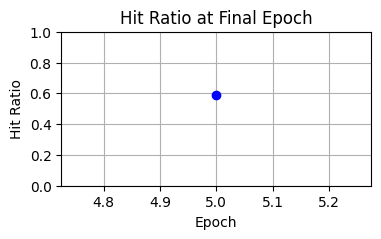

In [52]:
epochs = [5]
hr_scores = [0.59]

plt.figure(figsize=(4, 2))
plt.plot(epochs, hr_scores, marker='o', linestyle='-', color='b')
plt.title('Hit Ratio at Final Epoch')
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

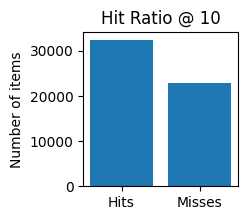

In [57]:
# Count the number of hits and misses
num_hits = sum(hits)
num_misses = len(hits) - num_hits

# Create a bar chart
plt.figure(figsize=(2, 2))
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()